# Import library

In [60]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torch.nn.functional as F
import torch.nn.init as init
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
from os.path import dirname, join as pjoin
import copy
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('visualization.ipynb'), '../')))
from utils.networks import *
from utils.trainer import *
from utils.formulations import *

datafolderpath = '../data'
saveresultfolderpath = '../experiment/result'
figurefolderpath = './saved_figures/'

def report_savefig(plotname, resultfolderpath = './', formattype = 'pdf', pad_margin = 0.01):
    fig.savefig(resultfolderpath + plotname + f'.{formattype}',format=formattype, 
                bbox_inches='tight',pad_inches=pad_margin,transparent=True)
    
def randomly_selected_date(df, random_seed = None):
    # Create a copy of df_test_date
    df = df.copy()
    
    # Get unique dates
    unique_dates = pd.Series(df_test_date.index.date).unique()
    # Set the random seed for reproducibility (optional)
    np.random.seed(random_seed)

    # Define the time range and frequency
    start_time = pd.to_datetime('06:45')
    end_time = pd.to_datetime('17:00')
    time_range = pd.date_range(start=start_time, end=end_time, freq='15T')

    while True:
        # Randomly select one date
        random_date = np.random.choice(unique_dates)

        # Filter the DataFrame for the selected date
        mask = df.index.date == random_date
        filtered_df = df[df.index.date == random_date]

        # Randomly select one Site_id if there are multiple entries
        if filtered_df['Site_id'].nunique() > 1:
            selected_site_id = np.random.choice(filtered_df['Site_id'].unique())
            # Update the mask to reflect the selection of a specific Site_id
            mask = mask & (df['Site_id'] == selected_site_id).to_numpy()  # Combine the original mask with the Site_id filter
            randomdate_df = filtered_df.loc[filtered_df['Site_id'] == selected_site_id]
        else:
            randomdate_df = filtered_df

        # Check if the first datetime is 06:45 and if all required times are present
        times_present = np.array([time in randomdate_df.index.time for time in time_range.time])

        if (len(randomdate_df) > 0 and  # Check if randomdate_df is not empty
            randomdate_df.index[0].time() == pd.to_datetime('06:45').time() and all(times_present)):
            break  # Exit the loop if the condition is met
    return randomdate_df, mask

# Import data

In [75]:
dict_path = os.path.join(datafolderpath, 'data_central_train_nonan.pkl')
with open(dict_path, 'rb') as pickle_file:
    data = pickle.load(pickle_file)
print(data.keys())

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

target_col = data['target_col']
features_list = data['features_list']
future_regressor = data['future_regressor']

df_test_date = data['df_test_date']
num_step_ahead = data['num_step_ahead']
resolution = data['resolution']

dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'target_col', 'features_list', 'future_regressor', 'df_train_nonan', 'df_val_nonan', 'df_test_nonan', 'df_train_date', 'df_val_date', 'df_test_date', 'timerange', 'num_step_ahead', 'resolution'])


# Import result

In [10]:
allresult_filename = ['sumk_solarcentral_4step_varylambda.pkl', 'sumk_lstm45_solarcentral_4step.pkl'
                      , 'qd_solarcentral_4step.pkl'
                      , 'cwcshri_solarcentral_4step.pkl', 'qr_solarcentral_4step.pkl']

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk_' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk_ann = pickle.load(pickle_file)
print(result_sumk_ann.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk_lstm45' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk_lstm = pickle.load(pickle_file)
#     result_sumk_lstm = torch.load(pickle_file, map_location=torch.device('cpu'))
print(result_sumk_lstm.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qd' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qd = pickle.load(pickle_file)
print(result_qd.keys()) 

index_path = next((i for i, s in enumerate(allresult_filename) if 'cwcshri' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_cwcshri = pickle.load(pickle_file)
print(result_cwcshri.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qr' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qr = pickle.load(pickle_file)
print(result_qr.keys())

## Define model and trainer
train = trainer_multistep(num_epochs = 2000, batch_size = 2000, patience = 200) #Set the trainer

dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'PICP_val', 'PICP_test', 'PINAW_test', 'PINALW_test', 'gamma', 'lambda'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])


# Compare the loss

In [22]:
criterion = sumk_objective(delta_ = 0.1, gamma_ = 0.15, percentlargest_ = 0.3, lambda_ = 0.9
                                              , soften_ = 50, smoothfunction = 'tanh', returnseparatedloss = False)

upper_ann = torch.tensor(result_sumk_ann['outputs_val'][:,1::2,9])
lower_ann = torch.tensor(result_sumk_ann['outputs_val'][:,0::2,9])

upper_lstm = result_sumk_lstm['outputs_val'][:,1::2]
lower_lstm = result_sumk_lstm['outputs_val'][:,0::2]

print(f'The validation loss of ANN is {criterion(y_val, lower_ann, upper_ann).item():.4f}.')
print(f'The validation loss of LSTM is {criterion(y_val, lower_lstm, upper_lstm).item():.4f}.')

The validation loss of ANN is 0.1341.
The validation loss of LSTM is 0.1284.


# Performance index

## Calculate evaluation metrices

In [78]:
key = 'outputs_test'
ydata = y_test
ydata_range = y_train

formname = ['QR', 'QD', 'CWCshri', 'Sumk ANN', 'Sumk LSTM']
method_list = [result_qr[key], result_qd[key], result_cwcshri[key]
           , torch.tensor(result_sumk_ann[key][:,:,9]), result_sumk_lstm[key]]
picp_array = np.zeros((len(method_list), num_step_ahead))
pinaw_array = np.zeros((len(method_list), num_step_ahead))
pinalw_array = np.zeros((len(method_list), num_step_ahead))
winkler_array = np.zeros((len(method_list), num_step_ahead))

for i, method in enumerate(method_list):
    upper = method[:,1::2]
    lower = method[:,0::2]
    picp_array[i,:] = train.PICP(ydata, upper, lower)
    pinaw_array[i,:] = train.PINAW(upper, lower, ydata_range)
    pinalw_array[i,:] = train.PINALW(upper, lower, ydata_range, quantile = 0.5)
    winkler_array[i,:] = train.Winklerscore(upper, lower, ydata, ydata_range, delta = 0.1)
    
metric_list = [picp_array, pinaw_array, pinalw_array, winkler_array]
metrices_namelist = ['PICP', 'PINAW', 'PINALW', 'Winkler']

## Latex table

In [79]:
decimalplaces = 3

latextable = '\\begin{table} \n\\begin{tabular}'
column_count = len(metric_list) + 1
column_spec = "".join(["p{2.8cm}" for _ in range(column_count)])
latextable += f'{{{column_spec}}} \n\\hline \n'

for i in range(num_step_ahead):
    latextable += f'\hline\n\multicolumn{{{column_count}}}{{c}}{{{(i+1)*resolution}-minutes ahead}} \\\\ \n\hline\n\hline\n'

    latextable += 'Method '
    for eval_name in metrices_namelist:
        latextable += f' & {eval_name}'
    latextable += '\\\\ \n\\hline\n'
    
    for j in range(len(method_list)):
        latextable += f'{formname[j]} '
        
        for metric in metric_list:
            nummetric = metric[j, i]
            latextable += f'& {nummetric:.{decimalplaces}f} '
        latextable += '\\\\ \n'
    latextable += '\hline\n'
    
latextable += '\\end{tabular} \n'
latextable += '\\end{table}'
print(latextable)

\begin{table} 
\begin{tabular}{p{2.8cm}p{2.8cm}p{2.8cm}p{2.8cm}p{2.8cm}} 
\hline 
\hline
\multicolumn{5}{c}{15-minutes ahead} \\ 
\hline
\hline
Method  & PICP & PINAW & PINALW & Winkler\\ 
\hline
QR & 0.912 & 0.395 & 0.638 & 0.484 \\ 
QD & 0.895 & 0.345 & 0.499 & 0.572 \\ 
CWCshri & 0.895 & 0.342 & 0.501 & 0.611 \\ 
Sumk ANN & 0.892 & 0.335 & 0.449 & 0.656 \\ 
Sumk LSTM & 0.892 & 0.340 & 0.442 & 0.675 \\ 
\hline
\hline
\multicolumn{5}{c}{30-minutes ahead} \\ 
\hline
\hline
Method  & PICP & PINAW & PINALW & Winkler\\ 
\hline
QR & 0.859 & 0.388 & 0.614 & 0.547 \\ 
QD & 0.902 & 0.399 & 0.560 & 0.627 \\ 
CWCshri & 0.902 & 0.394 & 0.556 & 0.647 \\ 
Sumk ANN & 0.893 & 0.399 & 0.523 & 0.694 \\ 
Sumk LSTM & 0.887 & 0.377 & 0.498 & 0.666 \\ 
\hline
\hline
\multicolumn{5}{c}{45-minutes ahead} \\ 
\hline
\hline
Method  & PICP & PINAW & PINALW & Winkler\\ 
\hline
QR & 0.898 & 0.449 & 0.681 & 0.569 \\ 
QD & 0.893 & 0.458 & 0.642 & 0.644 \\ 
CWCshri & 0.900 & 0.457 & 0.653 & 0.643 \\ 
Sumk ANN & 0.8

# Bar graph

In [26]:
key = 'outputs_test'
ydata = y_test
ydata_range = None

method_list = [result_qr[key], result_qd[key], result_cwcshri[key]
           , torch.tensor(result_sumk_ann[key][:,:,9]), result_sumk_lstm[key]]

formname = ['QR', 'QD', 'CWCshri', 'Sumk ANN', 'Sumk LSTM']
metrices_namelist = ['PICP', 'PINAW ($\wm$)', 'PINALW ($\wm$)', 'Winkler ($\wm$)']

picp_array = np.zeros((len(method_list), num_step_ahead))
pinaw_array = np.zeros((len(method_list), num_step_ahead))
pinalw_array = np.zeros((len(method_list), num_step_ahead))
winkler_array = np.zeros((len(method_list), num_step_ahead))

for i, method in enumerate(method_list):
    upper = method[:,1::2]
    lower = method[:,0::2]
    picp_array[i,:] = train.PICP(ydata, upper, lower)
    pinaw_array[i,:] = train.PINAW(upper, lower, ydata_range)
    pinalw_array[i,:] = train.PINALW(upper, lower, ydata_range, quantile = 0.5)
    winkler_array[i,:] = train.Winklerscore(upper, lower, ydata, ydata_range, delta = 0.1)
    
metric_list = [picp_array, pinaw_array, pinalw_array, winkler_array]

## Full version

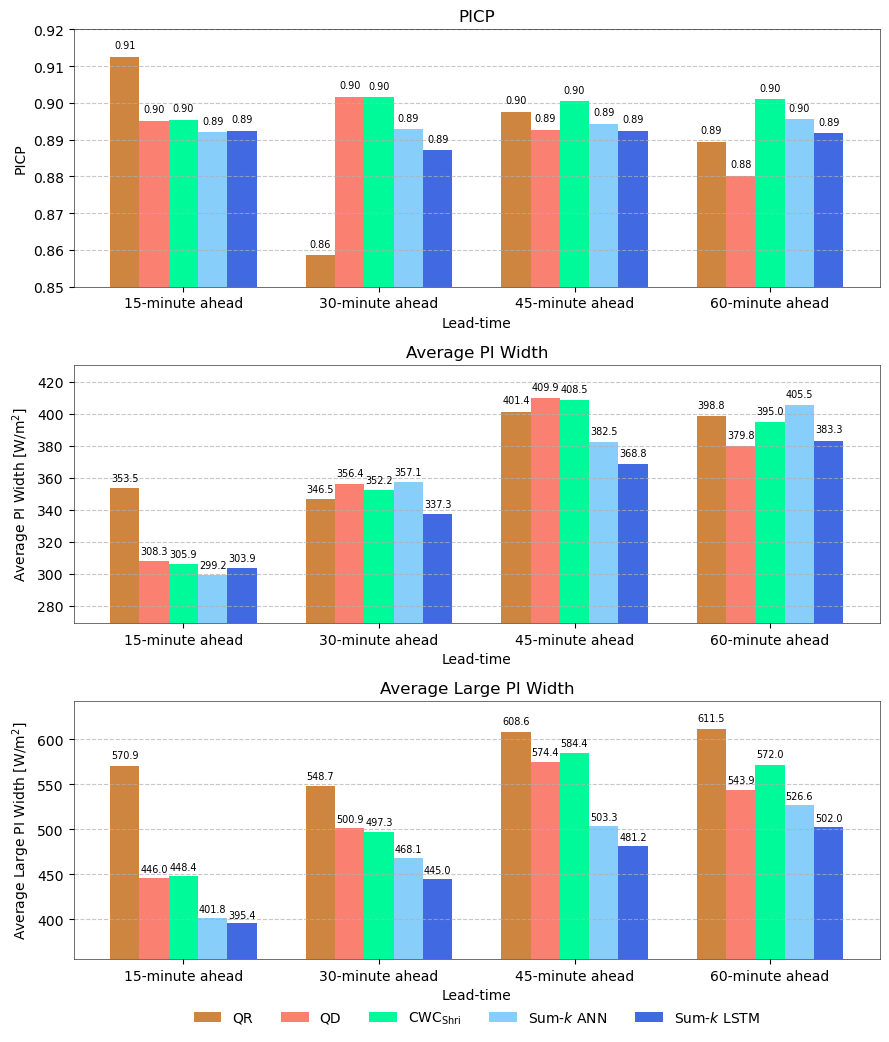

In [33]:
formname = ['QR', 'QD', r'$\text{CWC}_{\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']
horizons = ['15-minute ahead', '30-minute ahead', '45-minute ahead', '60-minute ahead']
width_plot_list = [picp_array, pinaw_array, pinalw_array]

fig, ax = plt.subplots(nrows = len(width_plot_list), figsize=(9, 3.5*len(width_plot_list)))
colors = ['peru', 'salmon', 'mediumspringgreen', 'lightskyblue', 'royalblue']
title_name = ['PICP', 'Average PI Width', 'Average Large PI Width']
ylabel_name = ['PICP', r'Average PI Width $[\text{W/m}^{2}]$', r'Average Large PI Width $[\text{W/m}^{2}]$']

for k, width_plot in enumerate(width_plot_list):
    # Parameters for bar plot
    num_horizons = width_plot.shape[1]  # Now this represents groups
    num_methods = width_plot.shape[0]   # Each horizon contains bars for different methods
    bar_width = 0.15
    indices = np.arange(num_horizons)
    offsets = [i * bar_width for i in range(num_methods)]

    for i, (method, offset) in enumerate(zip(formname, offsets)):
        ax[k].bar(indices + offset, width_plot[i], bar_width, label=method, color=colors[i])

        # Adding the numbers above each bar
        for j in range(num_horizons):
            if k == 0:
                ax[k].text(j + offset, width_plot[i, j]*1.002, f'{width_plot[i, j]:.2f}', ha='center', va='bottom'
                        , fontsize = 7)
                ax[k].set_ylim([0.85, 0.92])
            else:
                ax[k].text(j + offset, width_plot[i, j]*1.01, f'{width_plot[i, j]:.1f}', ha='center', va='bottom'
                        , fontsize = 7)
                ax[k].set_ylim([width_plot.min()*0.9, width_plot.max()*1.05])

    ax[k].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    # Labels and formatting
    ax[k].set_xlabel('Lead-time')
    ax[k].set_ylabel(f'{ylabel_name[k]}')
    ax[k].set_title(f'{title_name[k]}')
    ax[k].set_xticks(indices + bar_width * (num_methods - 1) / 2)
    ax[k].set_xticklabels(horizons)
    # ax.legend(loc = 'upper left', fontsize = 8)
    if k == len(width_plot_list)-1:
        ax[k].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=num_methods, fontsize=10, frameon = False)
        
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)

plt.tight_layout()
plt.show()
report_savefig('bar_solar_performance_comparison', resultfolderpath = figurefolderpath)

## Small version

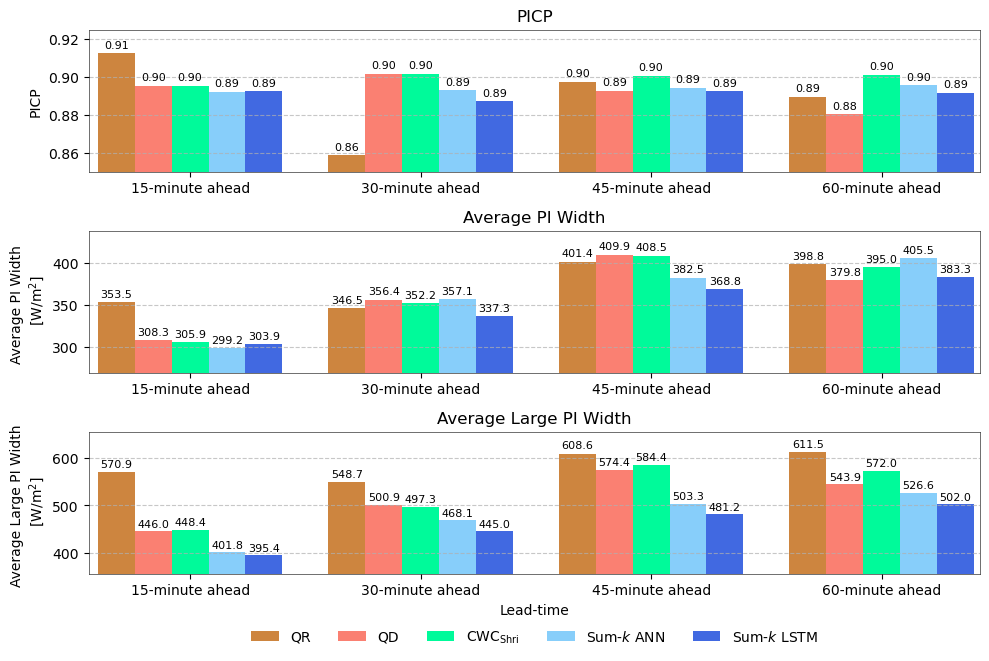

In [74]:
formname = ['QR', 'QD', r'$\text{CWC}_{\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']
horizons = ['15-minute ahead', '30-minute ahead', '45-minute ahead', '60-minute ahead']
width_plot_list = [picp_array, pinaw_array, pinalw_array]

fig, ax = plt.subplots(nrows = len(width_plot_list), figsize=(10, 2.25*len(width_plot_list)))
colors = ['peru', 'salmon', 'mediumspringgreen', 'lightskyblue', 'royalblue']
title_name = ['PICP', 'Average PI Width', 'Average Large PI Width']
ylabel_name = ['PICP', 'Average PI Width \n [W/m$^2$]', 'Average Large PI Width \n [W/m$^2$]']

ep = 0.01

for k, width_plot in enumerate(width_plot_list):
    # Parameters for bar plot
    num_horizons = width_plot.shape[1]  # Now this represents groups
    num_methods = width_plot.shape[0]   # Each horizon contains bars for different methods
    bar_width = 0.12
    indices = np.arange(num_horizons)*0.75
    offsets = [i * bar_width for i in range(num_methods)]

    for i, (method, offset) in enumerate(zip(formname, offsets)):
        ax[k].bar(indices + offset, width_plot[i], bar_width, label=method, color=colors[i])
        # Adding the numbers above each bar
        for j in range(num_horizons):
            if k == 0:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.002, f'{width_plot[i, j]:.2f}', ha='center', va='bottom'
                        , fontsize = 8)
                ax[k].set_ylim([0.85, 0.925])
            else:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.01, f'{width_plot[i, j]:.1f}', ha='center', va='bottom'
                        , fontsize = 8)
                ax[k].set_ylim([width_plot.min()*0.9, width_plot.max()*1.07])

    ax[k].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    # Labels and formatting
    if k == len(width_plot_list)-1:
        ax[k].set_xlabel('Lead-time')
    ax[k].set_ylabel(f'{ylabel_name[k]}')
#     ax[k].set_ylabel('Average PI Width \n W/m$^2$')
    ax[k].set_title(f'{title_name[k]}')
    ax[k].set_xticks(indices + bar_width * (num_methods - 1) / 2)
    ax[k].set_xticklabels(horizons)
    ax[k].set_xlim([-0.1+ep,2.82-ep])
#     ax[k].set_xlim(indices[0] - 0.2, indices[-1] + 0.2)
    # ax.legend(loc = 'upper left', fontsize = 8)
    if k == len(width_plot_list)-1:
        ax[k].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=num_methods, fontsize=10, frameon = False)
        
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)

plt.tight_layout()
plt.show()
# report_savefig('bar_solar_performance_comparison_compressed', resultfolderpath = figurefolderpath)

# Timeseries plot of 15-minute ahead PIs

## Groupping data

In [52]:
df = df_test_date.copy()
lamb_index = 9
outputs_test_sumk_plot = torch.tensor(result_sumk_ann['outputs_test'][:,:,lamb_index])
upper_sumk = outputs_test_sumk_plot[:,1::2]
lower_sumk = outputs_test_sumk_plot[:,0::2]
width_sumk = upper_sumk - lower_sumk
df['width_sumk_ahead15'] = width_sumk[:,0]

upper_qd = result_qd['outputs_test'][:,1::2]
lower_qd = result_qd['outputs_test'][:,0::2]
width_qd = upper_qd - lower_qd
df['width_qd_ahead15'] = width_qd[:,0]

upper_sumk_lstm = result_sumk_lstm['outputs_test'][:,1::2]
lower_sumk_lstm = result_sumk_lstm['outputs_test'][:,0::2]
width_sumk_lstm = upper_sumk_lstm - lower_sumk_lstm
df['width_sumk_lstm_ahead15'] = width_sumk_lstm[:,0]

df['Date'] = df.index.date
time_range = pd.date_range(start='06:45', end='17:00', freq='15T').time
df['counttimeslot'] = df.groupby(['Site_id', 'Date']).transform('count')['width_sumk_ahead15']
# Extract only full timeslot in the date
df = df[df['counttimeslot'] == len(time_range)] 

grouped_df = df.groupby(['Site_id', 'skycondition', 'Date', 'counttimeslot']).agg(
    avg_width_sumk_ahead15=('width_sumk_ahead15', 'mean'),
    avg_width_qd_ahead15=('width_qd_ahead15', 'mean'),
    avg_width_sumk_lstm_ahead15=('width_sumk_lstm_ahead15', 'mean')
).reset_index()

grouped_df['deviation'] = grouped_df['avg_width_qd_ahead15'] - grouped_df['avg_width_sumk_ahead15']
grouped_df['model_deviation'] = grouped_df['avg_width_sumk_ahead15'] - grouped_df['avg_width_sumk_lstm_ahead15']

# List of sky conditions to iterate over
sky_conditions = ['clearsky', 'partlycloudy', 'cloudy']

## Compare between Sum-k and QD

avg_width_qd_ahead15


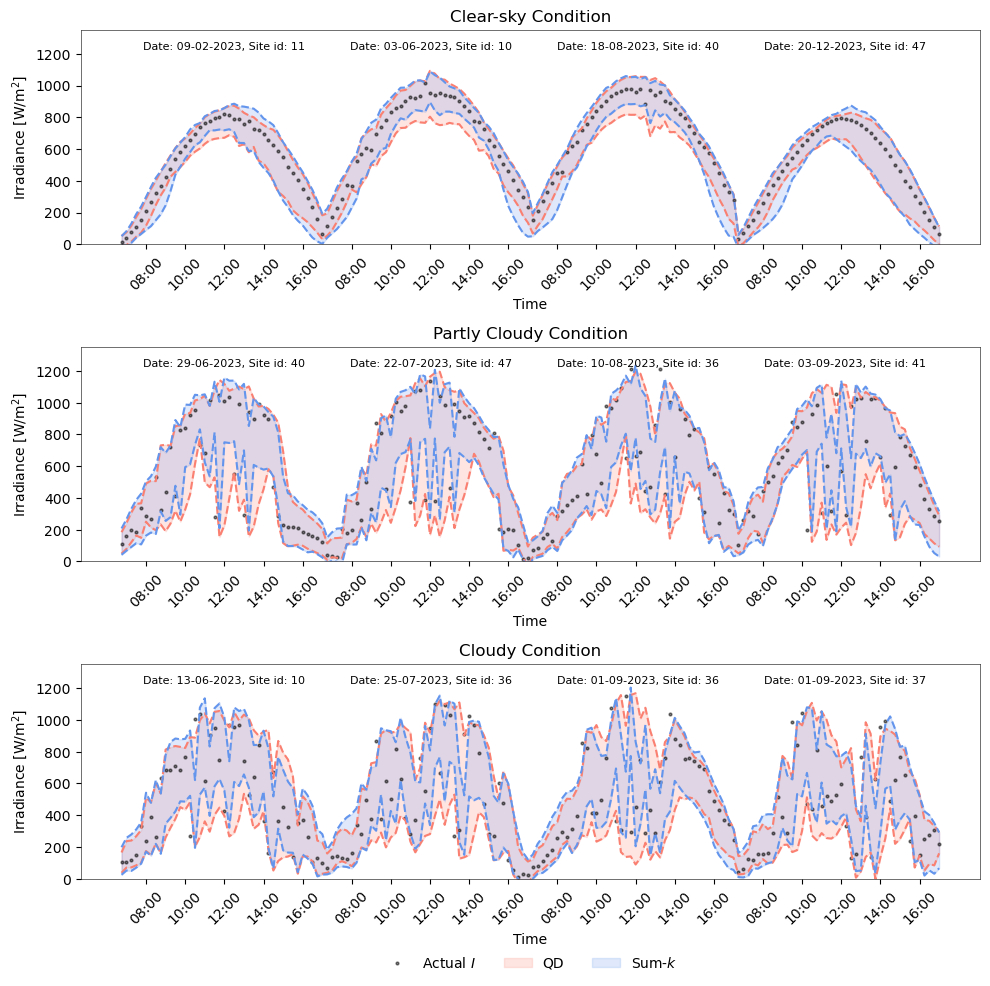

In [56]:
numcond = 1 # for compare QD and Sumk
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9])]
color_list = ['salmon', 'cornflowerblue']
formname_list = ['QD', 'Sum-$k$']

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    ax[i].set_xticks(xtick_positions)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=  3, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.16, 0.39, 0.62, 0.85]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
report_savefig('piplot_sepsky_solar_comparison_worstqdcond', resultfolderpath = figurefolderpath)

## Compare between Sum-k ANN and Sum-k LSTM

avg_width_sumk_ahead15


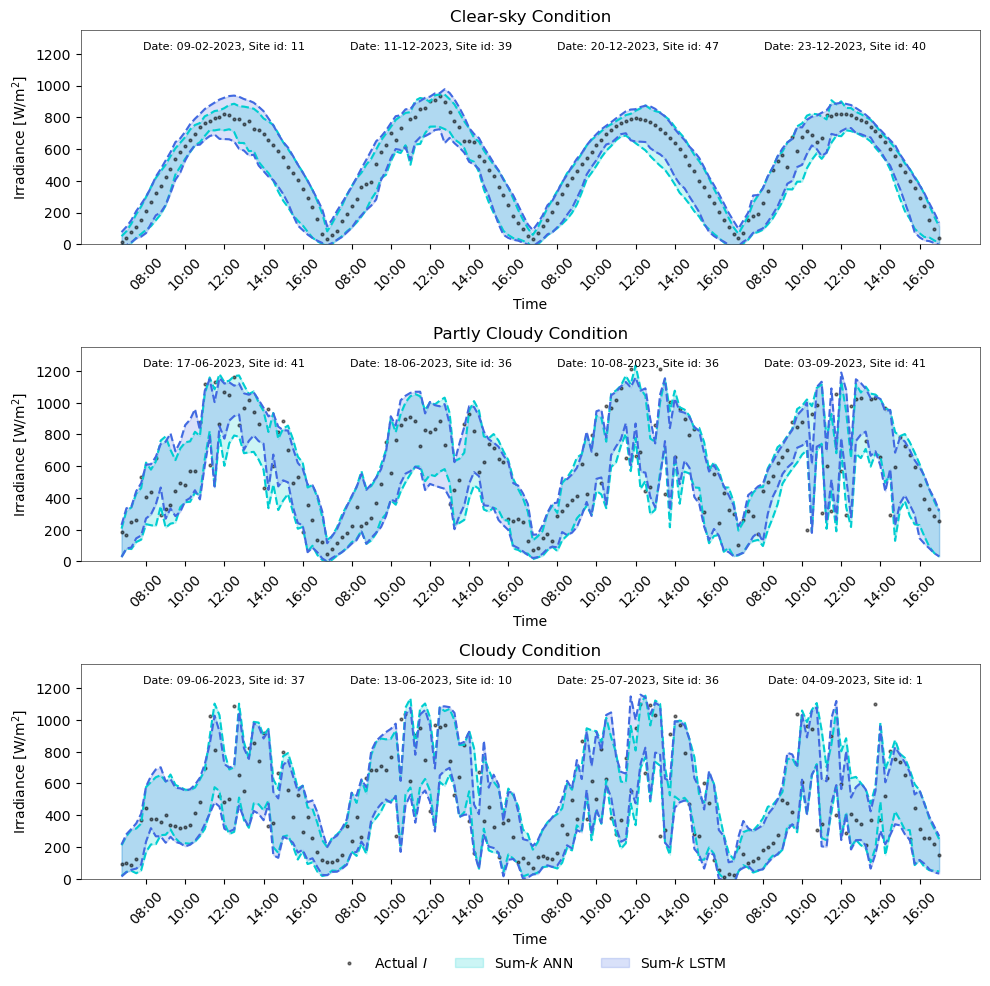

In [55]:
numcond = -1 # for compare ANN and LSTM
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['darkturquoise', 'royalblue']
formname_list = ['Sum-$k$ ANN', 'Sum-$k$ LSTM']

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    ax[i].set_xticks(xtick_positions)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=  3, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.16, 0.39, 0.62, 0.85]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

report_savefig('piplot_sepsky_solar_comparison_worstsumkanncond', resultfolderpath = figurefolderpath)

## Aggregated version

avg_width_qd_ahead15


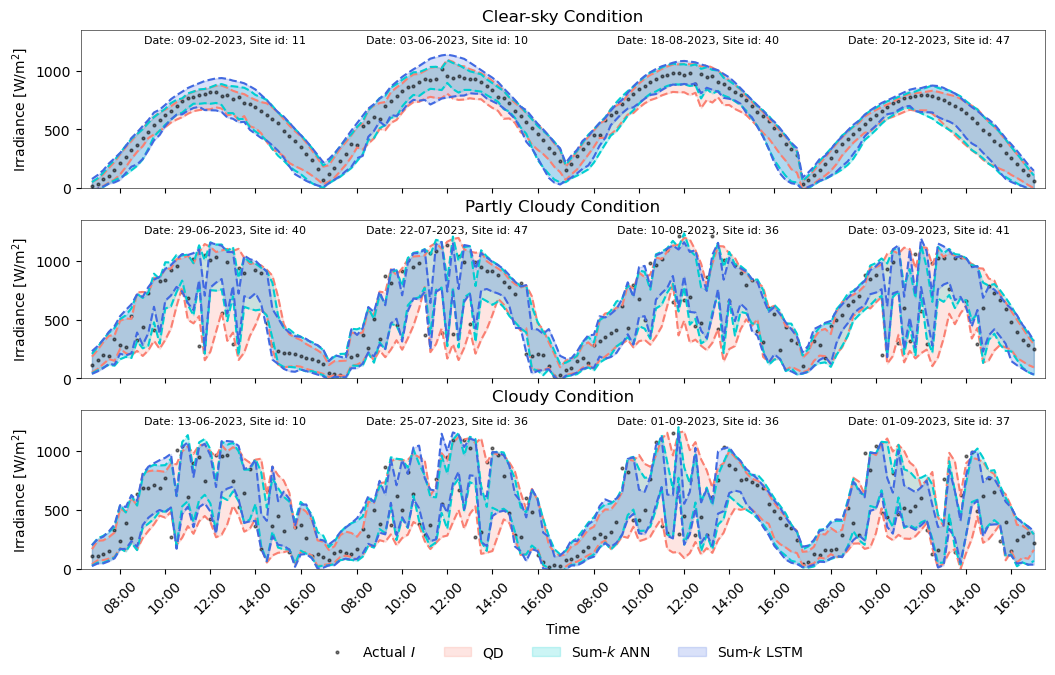

In [58]:
numcond = 1 # for compare QD and Sumk
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['salmon', 'darkturquoise', 'royalblue']
formname_list = ['QD', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']

fig, ax = plt.subplots(nrows=3, figsize=((16/9)*7, 1*7))
plt.subplots_adjust(hspace=0.2)

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    if i == len(allconditions)-1:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 
        
    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  4, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.15, 0.38, 0.64, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_sepsky_solar_comparison_worstqdcondwithlstm', resultfolderpath = figurefolderpath)

# Forecasting plot

Skycondition: partlycloudy
Date: 2023-08-21
Site id:11


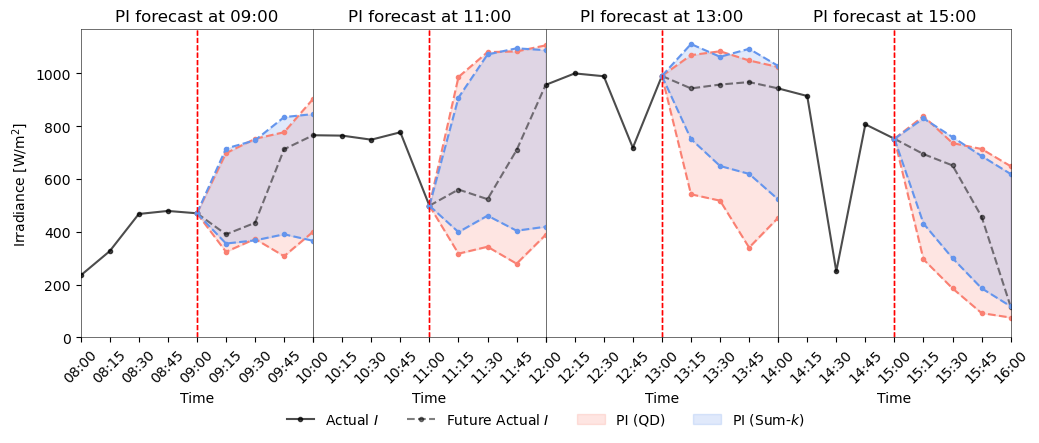

In [69]:
df = df_test_date.copy()
randomdate_df, mask_date = randomly_selected_date(df_test_date, random_seed = None)
# Select date for plot
mask_date = (df.index.date == pd.to_datetime('2023-08-21').date()) & (df['Site_id']==11).to_numpy()
randomdate_df = df[mask_date]

skycond = randomdate_df['skycondition'].iloc[0]
date = randomdate_df.index.date[0]
siteid = randomdate_df['Site_id'].iloc[0]
print(f'Skycondition: {skycond}')
print(f'Date: {date}')
print(f'Site id:{siteid}')

time_list_plot = ['09:00', '11:00', '13:00', '15:00']

pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9])]
color_list = ['salmon', 'cornflowerblue']
formname_list = ['QD', 'Sum-$k$']
max_upper = 0

if len(time_list_plot) == 1:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (8, 4))
    ax = [ax]
else:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (12, 4), gridspec_kw={'wspace': 0})

for i, time_plot in enumerate(time_list_plot):
    # Define the start and end times as datetime
    start_time = pd.to_datetime(time_list_plot[i]) - pd.Timedelta(hours=1)
    plot_time = pd.to_datetime(time_plot)

    time_mask = df.index.time == plot_time.time()
    mask = mask_date & time_mask
    # Generate the time range and extract the time part as a list
    time_steps_str = [t.strftime('%H:%M') for t in 
                      pd.date_range(start = start_time, end=plot_time + pd.Timedelta(hours=1)
                                    , freq='15T').time.tolist()]

    extracted_df = randomdate_df.between_time(start_time.time(), plot_time.time())
    historicaldata = (extracted_df['I']).to_numpy()
    targetahead = extracted_df.to_numpy()[-1, -4:]
    plotdata = np.hstack([historicaldata, targetahead])
    
    ax[i].plot(time_steps_str[:-4], plotdata[:-4], marker = '.', color = 'black', alpha = 0.7, label = r'Actual $I$')
    ax[i].plot(time_steps_str[-5:], plotdata[-5:], marker = '.', color = 'black',linestyle = 'dashed', alpha = 0.5
               , label = r'Future Actual $I$')
    
    for pi_plot, color, formname in zip(pi_plots, color_list, formname_list):
        upper = pi_plot[mask, 1::2].numpy().reshape(-1)
        lower = pi_plot[mask, 0::2].numpy().reshape(-1)
        
        if upper.max() > max_upper or plotdata.max() > max_upper:
            max_upper = max(upper.max(), plotdata.max())
        
        ax[i].plot(time_steps_str[-5:], np.insert(upper, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].plot(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].fill_between(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1]), np.insert(upper, 0, historicaldata[-1]), color = color, 
                              alpha = 0.2, label = f'PI ({formname})')
        ax[i].axvline(plot_time.strftime('%H:%M'), color='red', linestyle='--', linewidth = 1)
        
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'PI forecast at {time_plot}')
    ax[i].set_xticks(time_steps_str)  # Set x-ticks to the generated time strings
    ax[i].set_xticklabels(time_steps_str, rotation=45)
    ax[i].set_xlim([time_steps_str[0], time_steps_str[-1]])
    
    if i == len(time_list_plot)-2:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0, -0.2), ncol=  4, fontsize=10, frameon = False)

    if i == 0:
        ax[i].set_ylabel(r'Irradiance [$\text{W/m}^{2}$]')
    else:
        ax[i].tick_params(labelleft=False)  # Hide y-axis labels for other subplots
        ax[i].set_yticks([])
        xticks = ax[i].get_xticks()
        xtick_labels = ax[i].get_xticklabels()
        xtick_labels[0] = ''
        ax[i].set_xticklabels(xtick_labels)

    if i != len(time_list_plot)-1:
        ax[i].spines['right'].set_visible(False)

for i, time_plot in enumerate(time_list_plot):
    ax[i].set_ylim([0, max_upper*1.05])
    
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

datefilename = f'{date}'.replace('-','')
# report_savefig(f'piplot_forecast_horizontal_solar_comparison_{datefilename}_site{siteid}', resultfolderpath = figurefolderpath)


Skycondition: cloudy
Date: 2023-10-06
Site id:39


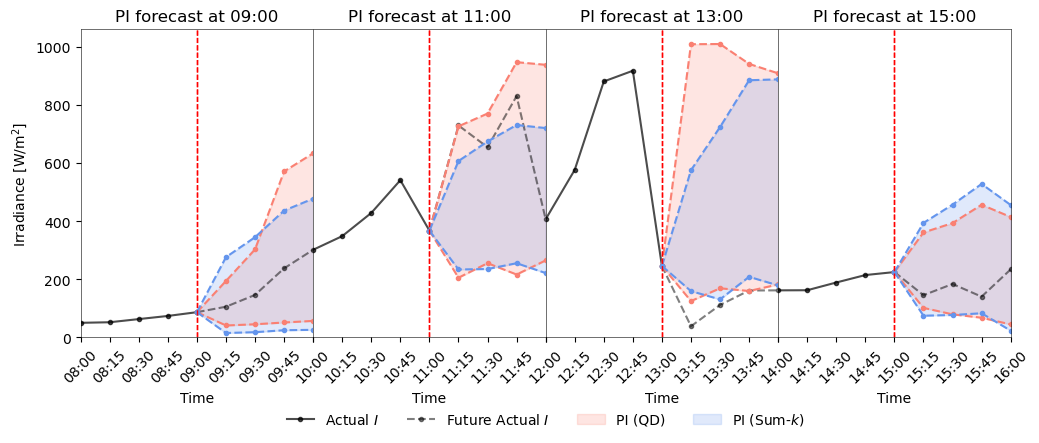

In [70]:
df = df_test_date.copy()
randomdate_df, mask_date =randomly_selected_date(df_test_date, random_seed = None)
# Select date for plot
mask_date = (df.index.date == pd.to_datetime('2023-10-06').date()) & (df['Site_id']==39).to_numpy()
randomdate_df = df[mask_date]

skycond = randomdate_df['skycondition'].iloc[0]
date = randomdate_df.index.date[0]
siteid = randomdate_df['Site_id'].iloc[0]
print(f'Skycondition: {skycond}')
print(f'Date: {date}')
print(f'Site id:{siteid}')

time_list_plot = ['09:00', '11:00', '13:00', '15:00']

pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9])]
color_list = ['salmon', 'cornflowerblue']
formname_list = ['QD', 'Sum-$k$']
max_upper = 0

if len(time_list_plot) == 1:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (8, 4))
    ax = [ax]
else:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (12, 4), gridspec_kw={'wspace': 0})

for i, time_plot in enumerate(time_list_plot):
    # Define the start and end times as datetime
    start_time = pd.to_datetime(time_list_plot[i]) - pd.Timedelta(hours=1)
    plot_time = pd.to_datetime(time_plot)

    time_mask = df.index.time == plot_time.time()
    mask = mask_date & time_mask
    # Generate the time range and extract the time part as a list
    time_steps_str = [t.strftime('%H:%M') for t in 
                      pd.date_range(start = start_time, end=plot_time + pd.Timedelta(hours=1)
                                    , freq='15T').time.tolist()]

    extracted_df = randomdate_df.between_time(start_time.time(), plot_time.time())
    historicaldata = (extracted_df['I']).to_numpy()
    targetahead = extracted_df.to_numpy()[-1, -4:]
    plotdata = np.hstack([historicaldata, targetahead])
    
    ax[i].plot(time_steps_str[:-4], plotdata[:-4], marker = '.', color = 'black', alpha = 0.7, label = r'Actual $I$')
    ax[i].plot(time_steps_str[-5:], plotdata[-5:], marker = '.', color = 'black',linestyle = 'dashed', alpha = 0.5
               , label = r'Future Actual $I$')
    
    for pi_plot, color, formname in zip(pi_plots, color_list, formname_list):
        upper = pi_plot[mask, 1::2].numpy().reshape(-1)
        lower = pi_plot[mask, 0::2].numpy().reshape(-1)
        
        if upper.max() > max_upper or plotdata.max() > max_upper:
            max_upper = max(upper.max(), plotdata.max())
        
        ax[i].plot(time_steps_str[-5:], np.insert(upper, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].plot(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].fill_between(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1]), np.insert(upper, 0, historicaldata[-1]), color = color, 
                              alpha = 0.2, label = f'PI ({formname})')
        ax[i].axvline(plot_time.strftime('%H:%M'), color='red', linestyle='--', linewidth = 1)
        
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'PI forecast at {time_plot}')
    ax[i].set_xticks(time_steps_str)  # Set x-ticks to the generated time strings
    ax[i].set_xticklabels(time_steps_str, rotation=45)
    ax[i].set_xlim([time_steps_str[0], time_steps_str[-1]])
    
    if i == len(time_list_plot)-2:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0, -0.2), ncol=  4, fontsize=10, frameon = False)

    if i == 0:
        ax[i].set_ylabel(r'Irradiance [$\text{W/m}^{2}$]')
    else:
        ax[i].tick_params(labelleft=False)  # Hide y-axis labels for other subplots
        ax[i].set_yticks([])
        xticks = ax[i].get_xticks()
        xtick_labels = ax[i].get_xticklabels()
        xtick_labels[0] = ''
        ax[i].set_xticklabels(xtick_labels)

    if i != len(time_list_plot)-1:
        ax[i].spines['right'].set_visible(False)

for i, time_plot in enumerate(time_list_plot):
    ax[i].set_ylim([0, max_upper*1.05])
    
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

datefilename = f'{date}'.replace('-','')
# report_savefig(f'piplot_forecast_horizontal_solar_comparison_{datefilename}_site{siteid}', resultfolderpath = figurefolderpath)
